# hit-song-classifier

## Random Forest Classification

The first thing we'll do is define our imports and declare any constants.


In [1]:
# Define our imports
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import DataFrame, SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

from sklearn.metrics import ConfusionMatrixDisplay

# Define our constants
TARGET_DATA = "../../data/spotify_enhanced_dataset_10.csv"
RANDOM_SEED = 0
TARGET_FEATURES = [
    "popularity",
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
    "time_signature",
]

Next, we shall split our data in a 60-20-20 train_test_val split. Then we shall build our set of inputs X. We don't want to include the features `[song, artist, year]` since they are keys. We also should define our label `class` since that is our classification feature.

In [2]:
def feature_transformer(df: DataFrame) -> DataFrame:
    """Assembles feature vectors in dataframe

    Args:
        df (DataFrame): input

    Returns:
        DataFrame: feature-label dataframe
    """
    va = VectorAssembler(inputCols=TARGET_FEATURES, outputCol="features")
    va_df = va.transform(df)
    return va_df


def load_data(filename: str) -> DataFrame:
    """Load data from file

    Args:
        filename (str): filename

    Returns:
        DataFrame: pyspark dataframe
    """
    spark = SparkSession.builder.appName("hit-song-classifier-rfc").getOrCreate()
    return spark.read.csv(filename, header=True, inferSchema=True)


def split_data(df: DataFrame) -> tuple[DataFrame, DataFrame, DataFrame]:
    """Splits data to train, val, test splits

    Args:
        df (DataFrame): full dataframe

    Returns:
        DataFrame: _description_
    """
    train, val, test = df.randomSplit([0.6, 0.2, 0.2], seed=RANDOM_SEED)
    return train, val, test


df = feature_transformer(load_data(TARGET_DATA))
train_df, val_df, test_df = split_data(df)
print(f"Train: {train_df.count()}\nTest: {test_df.count()}\nVal: {val_df.count()}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/01 22:41:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/04/01 22:41:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/04/01 22:42:00 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
Train: 6
Test: 0
Val: 3


## Hyperparameter search: training multiple estimators

Here we will train multiple estimators with different hyperparameter settings. For RandomForestClassifiers, the hyperparameters we've chosen include `maxDepth` and `numTrees`.

In [3]:
def train_estimators(
    data: DataFrame,
    estimator_type: any,
    param_name: str,
    param_vals: list[int],
    **kwargs,
) -> list:
    """Trains estimators

    Args:
        data (DataFrame): dataframe
        estimator_type (RandomForestClassifier): estimator
        param_name (str): parameter name
        param_vals (list[int]): parameter values

    Returns:
        list: list of trained estimators
    """
    estimators = []
    for val in param_vals:
        estimator = estimator_type(**{param_name: val}, **kwargs)
        fitted_models = estimator.fit(data)
        estimators.append(fitted_models)
        print(f"Training {fitted_models}")
    return estimators

### Hyperparameter search: `maxDepth`

Note that in Pyspark, the max depth is `30`.


In [4]:
max_depth = [1, 5, 10, 20, 30]
rfc_multi = train_estimators(
    train_df,
    RandomForestClassifier,
    "maxDepth",
    max_depth,
    featuresCol="features",
    labelCol="class",
    seed=RANDOM_SEED,
)

23/04/01 22:42:02 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 6 (= number of training instances)
Training RandomForestClassificationModel: uid=RandomForestClassifier_b564d6ab4164, numTrees=20, numClasses=9, numFeatures=14
23/04/01 22:42:04 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 6 (= number of training instances)
Training RandomForestClassificationModel: uid=RandomForestClassifier_f8c44c9d074d, numTrees=20, numClasses=9, numFeatures=14
23/04/01 22:42:04 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 6 (= number of training instances)
Training RandomForestClassificationModel: uid=RandomForestClassifier_52b6767dd0c0, numTrees=20, numClasses=9, numFeatures=14
23/04/01 22:42:05 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 6 (= number of training instances)
Training RandomForestClassificationModel: uid=RandomForestClassifier_9b7b946cbfbb, numTrees=20, numClasses=9, numFeatures=14
23/04/01 22:42:0

We want to plot estimator scores to pick the estimator with the best score.

In [5]:
def score_model(models: list, data: DataFrame) -> list:
    """Scores models

    Args:
        estimators (list): list of estimators
        data (DataFrame): dataframe

    Returns:
        list: list of scores
    """
    evaluator = MulticlassClassificationEvaluator(
        labelCol="class", predictionCol="prediction", metricName="f1"
    )

    predicted = [model.transform(data) for model in models]
    return [evaluator.evaluate(pred) for pred in predicted]


print(f"train: {score_model(rfc_multi, train_df)}")
print(f"val: {score_model(rfc_multi, val_df)}")
print(f"test: {score_model(rfc_multi, test_df)}")

train: [0.7619047619047619, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999]
val: [0.0, 0.0, 0.0, 0.0, 0.0]
test: [0.0, 0.0, 0.0, 0.0, 0.0]


### Hyperparameter search: `numTrees`


In [6]:
num_trees = [1, 5, 10, 20, 50, 100]
rfc_trees = train_estimators(
    train_df,
    RandomForestClassifier,
    "numTrees",
    num_trees,
    featuresCol="features",
    labelCol="class",
    seed=RANDOM_SEED,
)

23/04/01 22:42:09 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 6 (= number of training instances)
Training RandomForestClassificationModel: uid=RandomForestClassifier_54cbf81bb9ee, numTrees=1, numClasses=9, numFeatures=14
23/04/01 22:42:10 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 6 (= number of training instances)
Training RandomForestClassificationModel: uid=RandomForestClassifier_7c3c3da5fae7, numTrees=5, numClasses=9, numFeatures=14
23/04/01 22:42:11 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 6 (= number of training instances)
Training RandomForestClassificationModel: uid=RandomForestClassifier_59e945a49359, numTrees=10, numClasses=9, numFeatures=14
23/04/01 22:42:11 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 6 (= number of training instances)
Training RandomForestClassificationModel: uid=RandomForestClassifier_60626fdc3e32, numTrees=20, numClasses=9, numFeatures=14
23/04/01 22:42:12 

### Evaluate the F1 score of the hyperparameters for `max_depth` and `num_trees`

In [7]:
print(f"train: {score_model(rfc_trees, train_df)}")
print(f"val: {score_model(rfc_trees, val_df)}")
print(f"test: {score_model(rfc_trees, test_df)}")

train: [0.5833333333333334, 0.7777777777777778, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999]
val: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
test: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [8]:
def plot_estimator_scores(models: list, param_name: str, param_vals: list[int]):
    """Plots the scores of a list of estimators"""

    train_score = score_model(models, train_df)
    val_score = score_model(models, val_df)
    test_score = score_model(models, test_df)

    # Get the best validation score and the index of the best estimator
    best_val_score = max(val_score)
    best_val_idx = val_score.index(best_val_score)

    # Plot metrics
    plt.figure()
    plt.plot(np.arange(len(train_score)), train_score, "go-", label="train")
    plt.plot(np.arange(len(val_score)), val_score, "ro-", label="val")
    plt.plot(np.arange(len(test_score)), test_score, "k:", label="test")
    # Place an X at the best validation score
    plt.scatter(best_val_idx, best_val_score, marker="x", color="r", s=200)

    # Additional formatting
    plt.ylim(0, 1.05)
    plt.xticks(ticks=np.arange(len(train_score)), labels=param_vals)
    plt.ylabel("score")
    plt.xlabel(param_name)
    plt.title(f"{models[0].__class__.__name__} score vs. {param_name}")

    # Output scores at max_depth of the best_validation_score
    plt.text(
        3.7 if len(train_score) < 6 else 4.7,
        0.3,
        f"train = {train_score[best_val_idx]:.3f}",
        c="g",
        ha="right",
    )
    plt.text(
        3.7 if len(train_score) < 6 else 4.7,
        0.2,
        f"validate = {best_val_score:.3f}",
        c="r",
        ha="right",
    )
    plt.text(
        3.7 if len(train_score) < 6 else 4.7,
        0.1,
        f"test = {test_score[best_val_idx]:.3f}",
        c="k",
        ha="right",
    )
    plt.legend()

CPU times: user 222 ms, sys: 50 ms, total: 272 ms
Wall time: 1.96 s


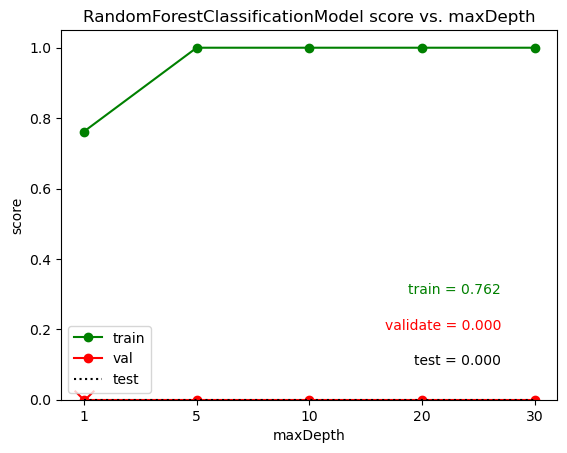

In [9]:
%%time
plot_estimator_scores(rfc_multi, "maxDepth", max_depth)

CPU times: user 185 ms, sys: 51.5 ms, total: 237 ms
Wall time: 2.4 s


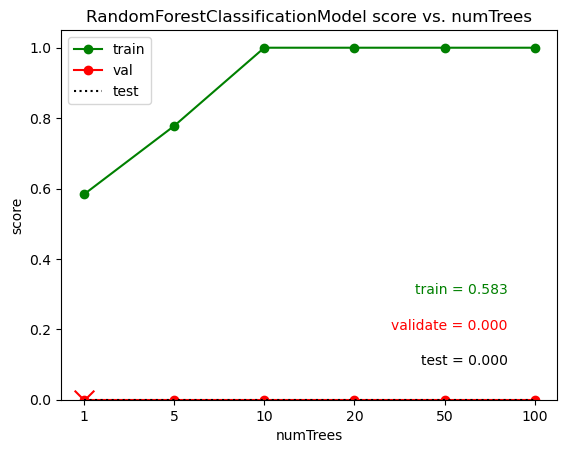

In [10]:
%%time
plot_estimator_scores(rfc_trees, "numTrees", num_trees)

## Evaluation using Confusion Matrices

/usr/local/Caskroom/miniconda/base/envs/soen/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


ValueError: RDD is empty

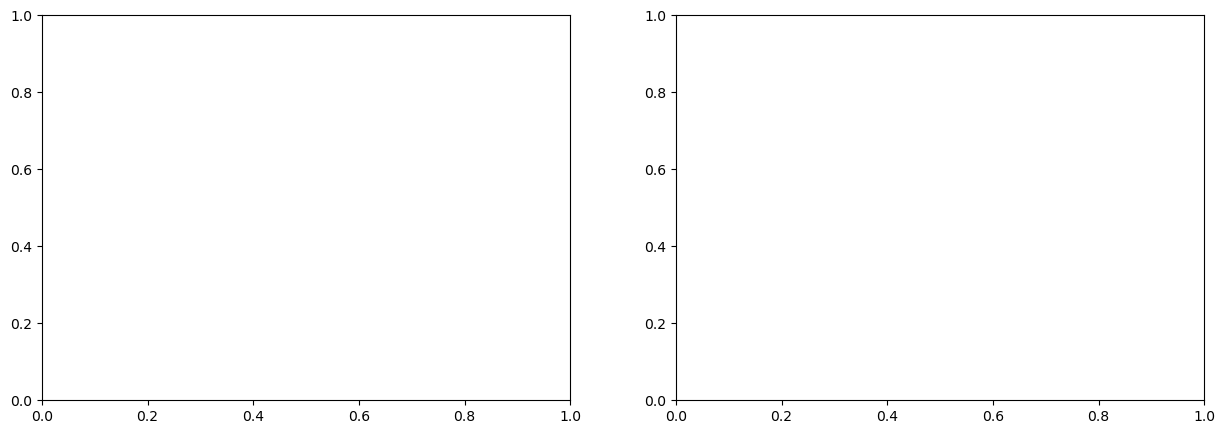

In [11]:
# Declare models and model names
model_list = [rfc_multi, rfc_trees]
model_names = ["RFC Max Depth", "RFC Num Trees"]


def generate_confusion_matrix(model_list: list, val_df: DataFrame, test_df: DataFrame):
    """Generates a confusion matrix for each model in model_list"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for i, model in enumerate(model_list):
        val_score = score_model(model, val_df)
        best_val_score = max(val_score)
        best_val_idx = val_score.index(best_val_score)

        # Generate confusion matrix
        best_model = (
            model[best_val_idx].transform(test_df).select("class", "prediction")
        )
        predictionAndLabels = best_model.rdd.map(
            lambda row: (float(row["prediction"]), float(row["class"]))
        )
        class_names = (
            best_model.select("class")
            .distinct()
            .sort("class")
            .rdd.map(lambda row: row[0])
            .collect()
        )
        metrics = MulticlassMetrics(predictionAndLabels)
        con_mtrx = metrics.confusionMatrix().toArray().astype(int)

        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(
            confusion_matrix=con_mtrx, display_labels=class_names
        )
        disp.plot(ax=axes[i], colorbar=False)
        axes[i % 2].set_title(model_names[i % 2])

    # Add colorbar
    fig.colorbar(disp.im_, ax=axes.ravel().tolist())


generate_confusion_matrix(model_list, val_df, test_df)

## Putting it all together using Cross-Validation

Since we evaluated the hyperparameters separately above, we should create a Pipeline in which the best hyperparameters are determined grid-wise. This should automate what we did above.

In [ ]:
def cross_validator(train_data: DataFrame) -> CrossValidatorModel:
    """Performs cross validation"""

    # Define the estimator
    rfc = RandomForestClassifier(
        featuresCol="features",
        labelCol="class",
        seed=RANDOM_SEED,
    )

    # Define the parameter grid
    param_grid = (
        ParamGridBuilder()
        .addGrid(rfc.maxDepth, max_depth)
        .addGrid(rfc.numTrees, num_trees)
        .build()
    )

    # Define the evaluator using F1 score
    evaluator = MulticlassClassificationEvaluator(
        labelCol="class", predictionCol="prediction", metricName="f1"
    )

    # Create the cross validator with 5 folds
    cv = CrossValidator(
        estimator=rfc, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3
    )
    cv_model = cv.fit(train_data)

    return cv_model


cv_model = cross_validator(train_df)

23/03/30 18:05:00 WARN DAGScheduler: Broadcasting large task binary with size 1101.5 KiB
23/03/30 18:05:01 WARN DAGScheduler: Broadcasting large task binary with size 1088.8 KiB
23/03/30 18:05:06 WARN DAGScheduler: Broadcasting large task binary with size 1038.0 KiB
23/03/30 18:05:07 WARN DAGScheduler: Broadcasting large task binary with size 1453.0 KiB


23/03/30 18:05:08 WARN DAGScheduler: Broadcasting large task binary with size 1854.7 KiB
23/03/30 18:05:09 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


23/03/30 18:05:10 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/03/30 18:05:11 WARN DAGScheduler: Broadcasting large task binary with size 1722.1 KiB
23/03/30 18:05:24 WARN DAGScheduler: Broadcasting large task binary with size 1101.5 KiB
23/03/30 18:05:24 WARN DAGScheduler: Broadcasting large task binary with size 1088.8 KiB
23/03/30 18:05:28 WARN DAGScheduler: Broadcasting large task binary with size 1038.0 KiB
23/03/30 18:05:28 WARN DAGScheduler: Broadcasting large task binary with size 1453.0 KiB
23/03/30 18:05:29 WARN DAGScheduler: Broadcasting large task binary with size 1854.7 KiB
23/03/30 18:05:29 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/03/30 18:05:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
23/03/30 18:05:30 WARN DAGScheduler: Broadcasting large task binary with size 1958.5 KiB
23/03/30 18:05:30 WARN DAGScheduler: Broadcasting large task binary with size 1306.0 KiB
23/03/30 18:05:32 WARN DAGSche

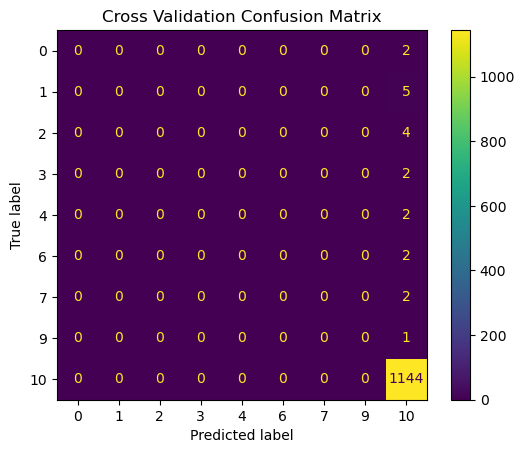

In [ ]:
def generate_cross_val_confusion_matrix(
    cv_model: CrossValidatorModel, test_df: DataFrame
):
    """Generates a confusion matrix for the best model from cross validation"""

    # Generate confusion matrix
    predictionAndLabels = (
        cv_model.transform(test_df)
        .select("class", "prediction")
        .rdd.map(lambda row: (float(row["prediction"]), float(row["class"])))
    )
    class_names = (
        test_df.select("class")
        .distinct()
        .sort("class")
        .rdd.map(lambda row: row[0])
        .collect()
    )
    metrics = MulticlassMetrics(predictionAndLabels)
    con_mtrx = metrics.confusionMatrix().toArray().astype(int)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=con_mtrx, display_labels=class_names)
    disp.plot()
    plt.title("Cross Validation Confusion Matrix")


generate_cross_val_confusion_matrix(cv_model, test_df)

### Explaining best hyperparameters

Now we should explain the best hyperparameters for the cross-validation model.


In [ ]:
print(cv_model.bestModel.explainParam("maxDepth"))
print(cv_model.bestModel.explainParam("numTrees"))

maxDepth: Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30]. (default: 5, current: 10)
numTrees: Number of trees to train (>= 1). (default: 20, current: 20)
